In [2]:
import os, glob
import pandas as pd
import numpy as np
import dask.dataframe as dd
from dask.delayed import delayed

In [2]:
path = "Processed_datasets/Processed_Network_dataset"
all_files = glob.glob(os.path.join(path, "*.csv"))
print(f"Found {len(all_files)} files.")

Found 23 files.


In [ ]:
# ## Just a little check to know what file has what column and what it doesnt have
# ## DO NOT RUN AGAIN!!!
# from collections import defaultdict

# # all_files should be your list of CSVs
# column_sources = defaultdict(list)

# for f in all_files:
#     cols = pd.read_csv(f, nrows=0).columns
#     for c in cols:
#         column_sources[c].append(os.path.basename(f))

# # Now you can query:
# for col, files in column_sources.items():
#     if len(files) == 1:  # appears in only one file
#         print(f"🟢 Column '{col}' is unique to {files[0]}")
#     else:
#         print(f"Column '{col}' appears in {len(files)} files (example: {files[:3]}...)")

In [3]:
all_columns = set()
for f in all_files:
    try:
        # read only the header; nrows=0 returns columns without loading rows
        cols = pd.read_csv(f, nrows=0).columns
        all_columns.update(cols)
    except Exception as e:
        print(f"[WARN] Skipping {os.path.basename(f)} header read error: {e}")

all_columns = list(all_columns)
print(f"Unified schema has {len(all_columns)} columns.")

Unified schema has 47 columns.


In [4]:
DEFAULT_MISSING = 0   # or `None` for NaN

def load_align_single_file(file_path, columns, default_value):
    """
    Load one CSV with dask, align to master schema by:
      - adding any missing columns
      - reordering columns
      - adding `source_file`
    Return a Dask DataFrame.
    """
    base = os.path.basename(file_path)

    # Use dtype="object" to avoid mixed-type crashes; cast later if needed
    # blocksize controls partition size; tune for your machine (e.g., 64MB, 128MB)
    ddf = dd.read_csv(
        file_path,
        dtype="object",
        assume_missing=True,
        blocksize="64MB",
        # If some rows are malformed, uncomment next line (pandas >= 1.3)
        # on_bad_lines="skip",
    )

    # Add missing columns lazily
    missing = [c for c in columns if c not in ddf.columns]
    if missing:
        # assign in one go
        ddf = ddf.assign(**{c: default_value for c in missing})

    # Reorder columns (columns not found will be added above)
    ddf = ddf[columns]

    # Add source_file
    ddf = ddf.assign(source_file=base)

    return ddf

In [5]:
aligned_ddfs = []
for f in all_files:
    try:
        ddf = load_align_single_file(f, all_columns, DEFAULT_MISSING)
        aligned_ddfs.append(ddf)
        print(f"Queued: {os.path.basename(f)}")
    except Exception as e:
        print(f"[WARN] Skipping {os.path.basename(f)} due to read error: {e}")

# ---- Concatenate lazily ----
if not aligned_ddfs:
    raise RuntimeError("No CSVs could be read. Check your path and permissions.")

network_ddf = dd.concat(aligned_ddfs, interleave_partitions=True)

Queued: Network_dataset_13.csv
Queued: Network_dataset_12.csv
Queued: Network_dataset_14.csv
Queued: Network_dataset_15.csv
Queued: Network_dataset_23.csv
Queued: Network_dataset_9.csv
Queued: Network_dataset_4.csv
Queued: Network_dataset_5.csv
Queued: Network_dataset_1.csv
Queued: Network_dataset_7.csv
Queued: Network_dataset_8.csv
Queued: Network_dataset_18.csv
Queued: Network_dataset_10.csv
Queued: Network_dataset_20.csv
Queued: Network_dataset_17.csv
Queued: Network_dataset_19.csv
Queued: Network_dataset_11.csv
Queued: Network_dataset_21.csv
Queued: Network_dataset_2.csv
Queued: Network_dataset_22.csv
Queued: Network_dataset_6.csv
Queued: Network_dataset_16.csv
Queued: Network_dataset_3.csv


In [6]:
network_ddf = network_ddf.astype({c: "string" for c in network_ddf.columns})

In [7]:
#### NO NEED TO RUN THIS AGAIN!
out_dir = "Processed_datasets/Processed_Network_dataset/Network_Combined_Parquet"
network_ddf.to_parquet(out_dir, engine="pyarrow", write_index=False)
print(f"✅ Wrote unified dataset to Parquet directory: {out_dir}")

✅ Wrote unified dataset to Parquet directory: Processed_datasets/Processed_Network_dataset/Network_Combined_Parquet


In [7]:
# # Peek a few rows (safe-ish)
# print(network_ddf.head(3))

  http_response_body_len  type uid ssl_subject         dst_ip label dst_bytes  \
0                      0  ddos   0           -  192.168.1.184     1         0   
1                      0  ddos   0           -    192.168.1.1     1        43   
2                      0  ddos   0           -  192.168.1.184     1         0   

  src_bytes http_orig_mime_types src_port  ... http_resp_mime_types  \
0         0                    -    41170  ...                    -   
1        82                    -    60830  ...                    -   
2         0                    -    41202  ...                    -   

  dst_ip_bytes ssl_version http_trans_depth dns_rejected        src_ip  \
0           60           -                -            -  192.168.1.31   
1           71           -                -            F  192.168.1.30   
2           60           -                -            -  192.168.1.31   

  dst_port proto              dns_query             source_file  
0      443   tcp           

In [8]:
#print("Columns:", network_ddf.columns.tolist()[:15], "...")
print("Columns:", network_ddf.columns.tolist())

Columns: ['dns_qclass', 'src_ip', 'dns_qtype', 'service', 'dst_ip_bytes', 'duration', 'dst_bytes', 'ssl_established', 'proto', 'ssl_subject', 'ssl_issuer', 'dst_pkts', 'src_bytes', 'http_request_body_len', 'weird_addl', 'dns_RD', 'ssl_resumed', 'conn_state', 'http_status_code', 'type', 'src_pkts', 'dns_rcode', 'dns_AA', 'dns_RA', 'http_user_agent', 'http_version', 'ts', 'dns_query', 'weird_name', 'ssl_cipher', 'http_uri', 'weird_notice', 'dst_ip', 'http_trans_depth', 'dst_port', 'http_method', 'dns_rejected', 'label', 'src_port', 'uid', 'ssl_version', 'http_resp_mime_types', 'http_referrer', 'http_orig_mime_types', 'http_response_body_len', 'missed_bytes', 'src_ip_bytes', 'source_file']


In [9]:
try:
    n_rows = network_ddf.shape[0].compute()
    n_cols = network_ddf.shape[1]
    print(f"Shape: {n_rows} rows × {n_cols} cols")
except Exception as e:
    print(f"[INFO] Skipped counting rows to save time: {e}")

Shape: 22339021 rows × 48 cols


In [23]:
## print head for just the uid column
print(network_ddf[["uid"]].head())

  uid
0   0
1   0
2   0
3   0
4   0


In [24]:
print(network_ddf.info())

<class 'dask.dataframe.dask_expr.DataFrame'>
Columns: 48 entries, http_orig_mime_types to source_file
dtypes: string(48)None


In [42]:
uniques = network_ddf["weird_name"].unique().compute()
print(uniques)

0                 irc_invalid_command
0                   inappropriate_FIN
0                         NUL_in_line
0    DNS_truncated_RR_rdlength_lt_len
0                 unknown_HTTP_method
0                                   -
1             dnp3_header_lacks_magic
0             active_connection_reuse
0             data_before_established
0       connection_originator_SYN_ack
1       TCP_ack_underflow_or_misorder
0        partial_escape_at_end_of_URI
0                    bad_TCP_checksum
1                  DNS_label_too_long
0      line_terminated_with_single_CR
0                     double_%_in_URI
0              possible_split_routing
0                    bad_HTTP_request
0                 DNS_RR_unknown_type
1    above_hole_data_without_any_acks
0                    bad_UDP_checksum
1        dnp3_corrupt_header_checksum
0                  unescaped_%_in_URI
Name: weird_name, dtype: string


In [43]:
counts = network_ddf["weird_name"].value_counts().compute()
print(counts)

weird_name
irc_invalid_command                        1
inappropriate_FIN                          8
NUL_in_line                                4
DNS_truncated_RR_rdlength_lt_len           1
unknown_HTTP_method                        2
-                                   22336134
dnp3_header_lacks_magic                    2
active_connection_reuse                  333
data_before_established                  145
TCP_ack_underflow_or_misorder            553
connection_originator_SYN_ack             85
partial_escape_at_end_of_URI               1
DNS_label_too_long                         1
bad_TCP_checksum                          64
line_terminated_with_single_CR            27
double_%_in_URI                            4
possible_split_routing                   327
bad_HTTP_request                           1
DNS_RR_unknown_type                     1150
above_hole_data_without_any_acks           6
bad_UDP_checksum                         116
dnp3_corrupt_header_checksum              31

In [7]:
## Replace "-" with nan
network_ddf = network_ddf.replace("-", np.nan)

In [11]:
counts = network_ddf["weird_name"].value_counts().compute()
print(counts)

weird_name
irc_invalid_command                    1
inappropriate_FIN                      8
NUL_in_line                            4
DNS_truncated_RR_rdlength_lt_len       1
unknown_HTTP_method                    2
dnp3_header_lacks_magic                2
active_connection_reuse              333
data_before_established              145
TCP_ack_underflow_or_misorder        553
connection_originator_SYN_ack         85
partial_escape_at_end_of_URI           1
DNS_label_too_long                     1
bad_TCP_checksum                      64
line_terminated_with_single_CR        27
double_%_in_URI                        4
possible_split_routing               327
bad_HTTP_request                       1
DNS_RR_unknown_type                 1150
above_hole_data_without_any_acks       6
bad_UDP_checksum                     116
dnp3_corrupt_header_checksum          31
unescaped_%_in_URI                    25
Name: count, dtype: Int64


#### Convert numerical columns to float

In [8]:
numeric_cols = ["src_port","dst_port","duration","src_bytes","dst_bytes",
                "missed_bytes","src_pkts","dst_pkts","src_ip_bytes","dst_ip_bytes",
                "dns_qclass","dns_qtype","dns_rcode","http_trans_depth",
                "http_request_body_len","http_response_body_len","http_status_code","label"]
for c in numeric_cols:
    if c in network_ddf.columns:
        network_ddf[c] = dd.to_numeric(network_ddf[c], errors="coerce").astype("float32")

#### Convert boolean columns to boolean

In [12]:
uniques = network_ddf["dns_AA"].unique().compute()
print(uniques)

0    <NA>
0       F
0       T
Name: dns_AA, dtype: string


In [12]:
# bool_cols = ["dns_AA","dns_RD","dns_RA","dns_rejected","ssl_resumed","ssl_established","weird_notice"]
# for c in bool_cols:
#     if c in network_ddf.columns:
#         network_ddf[c] = network_ddf[c].astype("boolean")

In [10]:
#DO NOT RUN THIS AGAIN
cols = ["dns_AA","dns_RD","dns_RA","dns_rejected","ssl_resumed","ssl_established","weird_notice"] 

for col in cols:
    uniques = network_ddf[col].unique().compute()
    print(f"Unique values in {col}: {uniques}")

Unique values in dns_AA: 0    <NA>
0       F
0       T
Name: dns_AA, dtype: string
Unique values in dns_RD: 0    <NA>
0       F
0       T
Name: dns_RD, dtype: string
Unique values in dns_RA: 0    <NA>
0       F
0       T
Name: dns_RA, dtype: string
Unique values in dns_rejected: 0    <NA>
0       F
0       T
Name: dns_rejected, dtype: string
Unique values in ssl_resumed: 0    <NA>
0       F
0       T
Name: ssl_resumed, dtype: string
Unique values in ssl_established: 0    <NA>
0       F
0       T
Name: ssl_established, dtype: string
Unique values in weird_notice: 0    <NA>
0       F
Name: weird_notice, dtype: string


#### Handle the N/A values to False before changing to boolean

In [9]:
bool_cols = ["dns_AA","dns_RD","dns_RA","dns_rejected","ssl_resumed","ssl_established","weird_notice"]
# Normalize, replace NA with "F", then map
for c in bool_cols:
    if c in network_ddf.columns:
        s = (network_ddf[c]
             .astype("string")         # ensures NA is preserved
             .str.strip().str.upper()
             .fillna("F"))             # replace NA with "F"

        # Convert T/F → True/False
        s = s.map({"T": True, "F": False}, meta=pd.Series([], dtype="boolean"))
        network_ddf[c] = s.astype("boolean")

In [10]:
print(network_ddf[bool_cols].dtypes)                 # all 'boolean'

dns_AA             boolean
dns_RD             boolean
dns_RA             boolean
dns_rejected       boolean
ssl_resumed        boolean
ssl_established    boolean
weird_notice       boolean
dtype: object


In [14]:
# now these ops are safe:
print(network_ddf[bool_cols].isna().sum().compute())

dns_AA             0
dns_RD             0
dns_RA             0
dns_rejected       0
ssl_resumed        0
ssl_established    0
weird_notice       0
dtype: int64


#### Label cleaning

In [11]:
#### covert label to int
network_ddf["label"] = dd.to_numeric(network_ddf["label"], errors="coerce").astype("int8")

In [32]:
uniques = network_ddf["type"].unique().compute()
print(uniques)

0           dos
0           xss
0      password
0        normal
0          ddos
1          mitm
0    ransomware
0     injection
1      backdoor
0      scanning
Name: type, dtype: string


In [17]:
#### convert type to all lowercase(already in lower)
network_ddf["type"]  = ddf["type"].str.lower()

In [12]:
print(network_ddf.info())

<class 'dask.dataframe.dask_expr.DataFrame'>
Columns: 48 entries, http_request_body_len to source_file
dtypes: boolean(7), float32(17), int8(1), string(23)None


#### Drop irrelevant columns

In [12]:
drop_cols = ["uid", "source_file", "ts"]

# Only drop the ones that actually exist (to avoid KeyError)
network_ddf = network_ddf.drop(
    columns=[c for c in drop_cols if c in network_ddf.columns],
    errors="ignore"
)

print("Remaining columns:", list(network_ddf.columns))


Remaining columns: ['ssl_version', 'http_response_body_len', 'http_version', 'weird_addl', 'ssl_resumed', 'dst_ip_bytes', 'label', 'type', 'http_user_agent', 'dns_RA', 'dns_qclass', 'dst_ip', 'ssl_established', 'http_method', 'http_status_code', 'http_request_body_len', 'weird_notice', 'src_ip', 'dns_RD', 'conn_state', 'ssl_cipher', 'http_orig_mime_types', 'missed_bytes', 'http_resp_mime_types', 'dst_port', 'ssl_subject', 'src_pkts', 'dns_rcode', 'weird_name', 'dns_qtype', 'dst_pkts', 'http_trans_depth', 'dns_AA', 'ssl_issuer', 'http_referrer', 'http_uri', 'dns_rejected', 'dns_query', 'duration', 'proto', 'src_bytes', 'src_port', 'service', 'dst_bytes', 'src_ip_bytes']


In [14]:
print(network_ddf.info())

<class 'dask.dataframe.dask_expr.DataFrame'>
Columns: 45 entries, ssl_version to src_ip_bytes
dtypes: boolean(7), float32(17), int8(1), string(20)None


## Handling missing values

#### Do one at a time, instead of all, DO NOT RUN THESE AGAIN!!!

In [19]:
subset = ['dns_qclass', 'src_ip', 'dns_qtype', 'service', 'dst_ip_bytes']
print(network_ddf[subset].isna().sum().compute())

dns_qclass             0
src_ip                 0
dns_qtype              0
service         16909396
dst_ip_bytes           0
dtype: int64


In [21]:
subset = ['duration', 'dst_bytes', 'proto', 'ssl_subject']
print(network_ddf[subset].isna().sum().compute())

duration              0
dst_bytes             0
proto                 0
ssl_subject    22316508
dtype: int64


In [22]:
subset = ['ssl_issuer', 'dst_pkts', 'src_bytes', 'http_request_body_len', 'weird_addl']
print(network_ddf[subset].isna().sum().compute())

ssl_issuer               22316508
dst_pkts                        0
src_bytes                     869
http_request_body_len           0
weird_addl               22337869
dtype: int64


In [23]:
subset = ['conn_state', 'http_status_code', 'type','src_pkts', 'dns_rcode']
print(network_ddf[subset].isna().sum().compute())

conn_state          0
http_status_code    0
type                0
src_pkts            0
dns_rcode           0
dtype: int64


In [24]:
subset = ['http_user_agent', 'http_version', 'dns_query', 'weird_name', 'ssl_cipher']
print(network_ddf[subset].isna().sum().compute())

http_user_agent    22314717
http_version       22315269
dns_query          20840602
weird_name         22336134
ssl_cipher         22315273
dtype: int64


In [25]:
subset = ['http_uri', 'dst_ip', 'http_trans_depth', 'dst_port', 'http_method']
print(network_ddf[subset].isna().sum().compute())

http_uri            22314711
dst_ip                     0
http_trans_depth    22314692
dst_port                   0
http_method         22314711
dtype: int64


In [26]:
subset = ['label', 'src_port', 'ssl_version', 'http_resp_mime_types', 'http_referrer']
print(network_ddf[subset].isna().sum().compute())

label                          0
src_port                       0
ssl_version             22315273
http_resp_mime_types    22332793
http_referrer           22339014
dtype: int64


In [27]:
subset = ['http_orig_mime_types', 'http_response_body_len', 'missed_bytes', 'src_ip_bytes']
print(network_ddf[subset].isna().sum().compute())

http_orig_mime_types      22337310
http_response_body_len           0
missed_bytes                     0
src_ip_bytes                     0
dtype: int64


In [ ]:
uniques = network_ddf["dns_rejected"].unique().compute()
print(uniques)

#### View the missing values of boolean

In [15]:
#### already resolved missing values for boolean
print(network_ddf[bool_cols].isna().sum().compute())

dns_AA             0
dns_RD             0
dns_RA             0
dns_rejected       0
ssl_resumed        0
ssl_established    0
weird_notice       0
dtype: int64


#### Handling Numeric missing values

In [15]:
numeric_cols = ["src_port","dst_port","duration","src_bytes","dst_bytes",
                "missed_bytes","src_pkts","dst_pkts","src_ip_bytes","dst_ip_bytes",
                "dns_qclass","dns_qtype","dns_rcode","http_trans_depth",
                "http_request_body_len","http_response_body_len","http_status_code","label"]


In [16]:
medians = {}
for c in numeric_cols:
    if c in network_ddf.columns:
        try:
            m = network_ddf[c].quantile(0.5).compute()   # approx median
            if np.isnan(m):   # all-NaN column fallback
                m = 0
        except Exception:
            m = 0
        medians[c] = m

print("Medians:", medians)

Medians: {'src_port': 59628.0, 'dst_port': 29600.0, 'duration': 60.2297420501709, 'src_bytes': 388.0, 'dst_bytes': 1919.0, 'missed_bytes': 0.0, 'src_pkts': 6.0, 'dst_pkts': 5.0, 'src_ip_bytes': 674.0, 'dst_ip_bytes': 2163.0, 'dns_qclass': 0.0, 'dns_qtype': 0.0, 'dns_rcode': 0.0, 'http_trans_depth': 1.0, 'http_request_body_len': 0.0, 'http_response_body_len': 0.0, 'http_status_code': 0.0, 'label': 1.0}


In [17]:
# Fill NaNs with the computed medians
for c, m in medians.items():
    network_ddf[c] = network_ddf[c].fillna(m)

In [37]:
print(network_ddf['src_bytes'].isna().sum().compute())

0


#### Handling missing categorical values

In [18]:
cat_missing = [
    "service","dns_query","ssl_version","ssl_cipher","ssl_subject","ssl_issuer",
    "http_method","http_uri","http_referrer","http_version",
    "http_user_agent","http_orig_mime_types","http_resp_mime_types",
    "weird_name","weird_addl"
]

In [19]:
low_card_cols = ["service","ssl_version","ssl_cipher","http_method","http_version","http_referrer","ssl_subject", "ssl_issuer", "weird_addl"]

low_card_cols = [c for c in low_card_cols if c in network_ddf.columns]

def most_frequent_value(dds, col):
    vc = dds[col].value_counts(split_out=8)  # split_out = parallel shuffle
    top = vc.nlargest(1).compute()
    return None if top.empty else top.index[0]

modes = {}
for c in low_card_cols:
    modes[c] = most_frequent_value(network_ddf, c)
    print(f"Mode for {c}: {modes[c]}")

for c, mode_val in modes.items():
    if mode_val is not None:
        network_ddf[c] = network_ddf[c].fillna(mode_val)

Mode for service: http
Mode for ssl_version: TLSv10
Mode for ssl_cipher: TLS_ECDHE_RSA_WITH_AES_256_CBC_SHA
Mode for http_method: POST
Mode for http_version: 1.1
Mode for http_referrer: http://192.168.1.195/dvwa/vulnerabilities/xss_r/?name=admin1&user_token=e00b97c522a500cb75e4fe645a588602
Mode for ssl_subject: CN=Mr Shepherd;OU=Security Shepherd Project;O=OWASP;L=Dublin;ST=Ireland;C=IE
Mode for ssl_issuer: CN=Mr Shepherd;OU=Security Shepherd Project;O=OWASP;L=Dublin;ST=Ireland;C=IE
Mode for weird_addl: 46


In [20]:
high_card_cols = [c for c in cat_missing if c not in low_card_cols]

for c in high_card_cols:
    if c in network_ddf.columns:
        network_ddf[c] = network_ddf[c].fillna("NA")

In [49]:
# print(network_ddf['service'].isna().sum().compute())

0


In [50]:
# #DO NOT RUN
# subset = ["dns_query","ssl_version","ssl_cipher","ssl_subject","ssl_issuer",
# "http_method","http_uri","http_referrer","http_version",
#     "http_user_agent","http_orig_mime_types","http_resp_mime_types",
#     "weird_name","weird_addl"]
# print(network_ddf[subset].isna().sum().compute())

dns_query               0
ssl_version             0
ssl_cipher              0
ssl_subject             0
ssl_issuer              0
http_method             0
http_uri                0
http_referrer           0
http_version            0
http_user_agent         0
http_orig_mime_types    0
http_resp_mime_types    0
weird_name              0
weird_addl              0
dtype: int64


#### save to another clean folder

In [21]:
import dask.dataframe as dd
# Path where you want to save parquet
out_dir = "Processed_datasets/Network_Clean_BeforeEncoding"

# Save Dask DataFrame as Parquet
# engine="pyarrow" is recommended, write_index=False avoids storing the index
network_ddf.to_parquet(
    out_dir,
    engine="pyarrow",
    write_index=False,
    overwrite=True  # overwrite if dir exists
)

print(f"✅ Clean dataset written to Parquet: {out_dir}")

# Verify: read back schema quickly
test_ddf = dd.read_parquet(out_dir)
print("Saved columns:", list(test_ddf.columns))
#print("Total rows:", test_ddf.shape[0].compute())


✅ Clean dataset written to Parquet: Processed_datasets/Network_Clean_BeforeEncoding
Saved columns: ['http_request_body_len', 'src_ip', 'dns_RD', 'conn_state', 'src_ip_bytes', 'service', 'weird_name', 'proto', 'type', 'duration', 'dst_ip', 'weird_notice', 'ssl_cipher', 'ssl_resumed', 'http_status_code', 'ssl_issuer', 'http_user_agent', 'weird_addl', 'dst_bytes', 'src_port', 'dst_pkts', 'dns_query', 'dns_qtype', 'dns_RA', 'http_resp_mime_types', 'dst_port', 'dst_ip_bytes', 'dns_qclass', 'http_trans_depth', 'http_version', 'http_response_body_len', 'dns_rejected', 'http_referrer', 'dns_AA', 'src_bytes', 'src_pkts', 'dns_rcode', 'http_method', 'ssl_established', 'ssl_version', 'http_orig_mime_types', 'label', 'ssl_subject', 'missed_bytes', 'http_uri']


#### The above section handled the filling of missing values, while this next section handled other processing like dropping irrelevant columns, nomalizing booleans and categoricals, and conversion to proper datatypes, split to train/test/val, training and evaluation

## Reprocessing with selected features

In [1]:
# Load IoT-IDS dataset (Network_Clean_BeforeEncoding) from Parquet with Dask 
import dask.dataframe as dd

DATA_DIR = "Processed_datasets/Network_Clean_BeforeEncoding"

keep_cols = [
    # numeric
    "duration","src_bytes","dst_bytes","src_pkts","dst_pkts","missed_bytes",
    "src_ip_bytes","dst_ip_bytes","http_request_body_len","http_response_body_len",
    "http_trans_depth","http_status_code",
    # ports (consider bucketing later)
    "src_port","dst_port",
    # categorical protocol/state
    "proto","service","conn_state","http_method","http_user_agent",
    "http_resp_mime_types","http_orig_mime_types","ssl_version","ssl_cipher","weird_name",
    # DNS codes/flags
    "dns_qtype","dns_qclass","dns_rcode","dns_RD","dns_RA","dns_AA","dns_rejected",
    # TLS and other booleans
    "ssl_established","ssl_resumed","weird_notice",
]

TARGET_COL = "type"     # <-- prediction target (multiclass)
AUX_COL    = "label"    # <-- keep this too

# 1) Read all parquet files
ddf_all = dd.read_parquet(f"{DATA_DIR}/*.parquet", engine="pyarrow", gather_statistics=True)

# 2) Keep only features + target + aux (and warn on any missing)
wanted = keep_cols + [TARGET_COL, AUX_COL]
available = [c for c in wanted if c in ddf_all.columns]
missing = sorted(set(wanted) - set(available))
if missing:
    print("⚠️ Missing expected columns:", missing)

ddf = ddf_all[available]

# (Optional) cast common boolean-like columns to bool if they’re 0/1 ints
bool_like = [c for c in ["dns_RD","dns_RA","dns_AA","dns_rejected","ssl_established","ssl_resumed","weird_notice"]
             if c in ddf.columns]
for c in bool_like:
    ddf[c] = ddf[c].astype("boolean")  # nullable boolean

# 3) Split features/targets (lazy; no compute yet)
X_ddf       = ddf[[c for c in keep_cols if c in ddf.columns]]
y_type_ddf  = ddf[TARGET_COL] if TARGET_COL in ddf.columns else None  # prediction target
y_label_ddf = ddf[AUX_COL]     if AUX_COL in ddf.columns else None    # kept for reference

# Quick sanity checks (trigger a tiny compute)
print("Columns loaded:", list(ddf.columns))
print("Sample rows:\n", ddf.head(3))

Columns loaded: ['duration', 'src_bytes', 'dst_bytes', 'src_pkts', 'dst_pkts', 'missed_bytes', 'src_ip_bytes', 'dst_ip_bytes', 'http_request_body_len', 'http_response_body_len', 'http_trans_depth', 'http_status_code', 'src_port', 'dst_port', 'proto', 'service', 'conn_state', 'http_method', 'http_user_agent', 'http_resp_mime_types', 'http_orig_mime_types', 'ssl_version', 'ssl_cipher', 'weird_name', 'dns_qtype', 'dns_qclass', 'dns_rcode', 'dns_RD', 'dns_RA', 'dns_AA', 'dns_rejected', 'ssl_established', 'ssl_resumed', 'weird_notice', 'type', 'label']
Sample rows:
    duration  src_bytes  dst_bytes  src_pkts  dst_pkts  missed_bytes  \
0  0.000003        0.0        0.0       2.0       1.0           0.0   
1  2.428448       82.0       43.0       2.0       1.0           0.0   
2  0.000003        0.0        0.0       1.0       1.0           0.0   

   src_ip_bytes  dst_ip_bytes  http_request_body_len  http_response_body_len  \
0         112.0          60.0                    0.0               

In [2]:
import pandas as pd

# 1) List columns
print("Columns:", list(ddf.columns))

Columns: ['duration', 'src_bytes', 'dst_bytes', 'src_pkts', 'dst_pkts', 'missed_bytes', 'src_ip_bytes', 'dst_ip_bytes', 'http_request_body_len', 'http_response_body_len', 'http_trans_depth', 'http_status_code', 'src_port', 'dst_port', 'proto', 'service', 'conn_state', 'http_method', 'http_user_agent', 'http_resp_mime_types', 'http_orig_mime_types', 'ssl_version', 'ssl_cipher', 'weird_name', 'dns_qtype', 'dns_qclass', 'dns_rcode', 'dns_RD', 'dns_RA', 'dns_AA', 'dns_rejected', 'ssl_established', 'ssl_resumed', 'weird_notice', 'type', 'label']


In [3]:
first_pdf = ddf.head(1)          # brings a tiny chunk into pandas
first_row = first_pdf.iloc[0]
summary = pd.DataFrame({"column": first_row.index, "first_value": first_row.values})
print(summary)

                    column                         first_value
0                 duration                            0.000003
1                src_bytes                                 0.0
2                dst_bytes                                 0.0
3                 src_pkts                                 2.0
4                 dst_pkts                                 1.0
5             missed_bytes                                 0.0
6             src_ip_bytes                               112.0
7             dst_ip_bytes                                60.0
8    http_request_body_len                                 0.0
9   http_response_body_len                                 0.0
10        http_trans_depth                                 1.0
11        http_status_code                                 0.0
12                src_port                             41170.0
13                dst_port                               443.0
14                   proto                             

In [2]:
# --- Normalize booleans + categoricals on existing `ddf` ---
import pandas as pd
import numpy as np

# Boolean flags present in your keep_cols (only keep those that exist)
bool_cols = [c for c in [
    "dns_RD","dns_RA","dns_AA","dns_rejected",
    "ssl_established","ssl_resumed","weird_notice",
] if c in ddf.columns]

# Categorical/text columns to normalize (only those that exist)
cat_cols = [c for c in [
    "proto","service","conn_state","http_method","http_user_agent",
    "http_resp_mime_types","http_orig_mime_types","ssl_version","ssl_cipher",
    "weird_name","dns_qtype","dns_qclass","dns_rcode",
    # include if present in your data:
    "http_version",
] if c in ddf.columns]

In [3]:
import pandas as pd
from pandas.api import types as ptypes

TRUE_TOKENS  = {"true","1","t","yes","y"}
FALSE_TOKENS = {"false","0","f","no","n",""}

def to_bool_strict(s: pd.Series) -> pd.Series:
    # Already boolean? just fill and cast to plain bool
    if ptypes.is_bool_dtype(s):
        return s.fillna(False).astype("bool")

    # Numeric? non-zero -> True, zero/NaN -> False
    if ptypes.is_numeric_dtype(s):
        s_num = pd.to_numeric(s, errors="coerce")
        return s_num.fillna(0).astype("int8").ne(0).astype("bool")

    # Strings/objects
    s_obj = s.astype("object")
    def norm(x):
        if isinstance(x, str):
            x = x.strip().lower()
            if x in TRUE_TOKENS:  return True
            if x in FALSE_TOKENS: return False
        elif x in (1, True):   return True
        elif x in (0, False):  return False
        # anything else (None, "", unknown tokens) -> False
        return False

    return s_obj.map(norm).astype("bool")

In [4]:
def normalize_flags_and_cats(pdf: pd.DataFrame) -> pd.DataFrame:
    pdf = pdf.copy()
    for c in bool_cols:
        pdf[c] = to_bool_strict(pdf[c])                  # <-- no NaNs left
    for c in cat_cols:
        s = pdf[c].astype("object")
        pdf[c] = s.map(lambda x: x.strip().lower() if isinstance(x, str) else x).astype("object")
    return pdf

# Build explicit meta to keep Dask happy with dtypes
from dask.dataframe.utils import make_meta
_meta = make_meta(normalize_flags_and_cats(ddf._meta_nonempty))
ddf = ddf.map_partitions(normalize_flags_and_cats, meta=_meta)

# sanity check
print(ddf[bool_cols].dtypes)   # all bool

dns_RD             bool
dns_RA             bool
dns_AA             bool
dns_rejected       bool
ssl_established    bool
ssl_resumed        bool
weird_notice       bool
dtype: object


In [7]:
# --- 4) Quick peeks ---
print("\nDtypes snapshot:\n", ddf.dtypes)
first = ddf.head(1)
print("\nFirst row snapshot:\n", first.T.rename(columns={first.index[0]: "first_value"}))


Dtypes snapshot:
 duration                          float32
src_bytes                         float32
dst_bytes                         float32
src_pkts                          float32
dst_pkts                          float32
missed_bytes                      float32
src_ip_bytes                      float32
dst_ip_bytes                      float32
http_request_body_len             float32
http_response_body_len            float32
http_trans_depth                  float32
http_status_code                  float32
src_port                          float32
dst_port                          float32
proto                              object
service                            object
conn_state                         object
http_method                        object
http_user_agent                    object
http_resp_mime_types               object
http_orig_mime_types               object
ssl_version                        object
ssl_cipher                         object
weird_name     

In [5]:
# Columns to cast to integers (keep only ones that exist)
int_cols = [c for c in ["src_port","dst_port","http_status_code",
                        "dns_qtype","dns_qclass","dns_rcode"] if c in ddf.columns]

def _safe_int_cast(pdf: pd.DataFrame) -> pd.DataFrame:
    pdf = pdf.copy()
    for c in int_cols:
        # Coerce -> numeric, replace ±inf/NaN with 0, then cast to int32
        s = pd.to_numeric(pdf[c], errors="coerce").replace([np.inf, -np.inf], np.nan).fillna(0)
        pdf[c] = s.astype("int32")
    return pdf

# Give Dask an explicit schema and apply
_meta = make_meta(_safe_int_cast(ddf._meta_nonempty))
ddf = ddf.map_partitions(_safe_int_cast, meta=_meta)

# Quick verification
print(ddf[int_cols].dtypes)          # expect int32
print(ddf[int_cols].head(3))         # tiny peek

src_port            int32
dst_port            int32
http_status_code    int32
dns_qtype           int32
dns_qclass          int32
dns_rcode           int32
dtype: object
   src_port  dst_port  http_status_code  dns_qtype  dns_qclass  dns_rcode
0     41170       443                 0          0           0          0
1     60830        53                 0          1           1          0
2     41202       443                 0          0           0          0


In [6]:
import dask.dataframe as dd

cls2idx = {
    "mitm":0, "ransomware":1, "injection":2, "backdoor":3, "normal":4,
    "password":5, "xss":6, "dos":7, "ddos":8, "scanning":9
}

# 1) (optional) sanity check — you've already done this and got only the 10 classes
# norm_counts = (
#     ddf["type"].astype("object").map(lambda x: x.strip().lower() if isinstance(x,str) else x)
#     .value_counts().compute()
# )

# 2) Map names -> ids with explicit meta so Dask doesn't guess (and doesn't use dummy 'a')
ddf["type"] = ddf["type"].map_partitions(
    lambda s: s.astype("object").str.strip().str.lower().map(cls2idx).astype("int8"),
    meta=("type", "int8"),
)

# 3) Quick check
print("type dtype:", ddf["type"].dtype)  # int8
#print("type counts:", ddf["type"].value_counts().compute().sort_index().to_dict())


type dtype: int8


In [10]:
# # Raw uniques (could be large). Safer: value_counts
# uniques_raw = ddf["type"].dropna().unique().compute()
# print("Raw unique values in `type`:", sorted(map(str, uniques_raw))[:200])


Raw unique values in `type`: ['backdoor', 'ddos', 'dos', 'injection', 'mitm', 'normal', 'password', 'ransomware', 'scanning', 'xss']


In [7]:
# --- 4) Quick peeks ---
print("\nDtypes snapshot:\n", ddf.dtypes)
first = ddf.head(1)
print("\nFirst row snapshot:\n", first.T.rename(columns={first.index[0]: "first_value"}))


Dtypes snapshot:
 duration                  float32
src_bytes                 float32
dst_bytes                 float32
src_pkts                  float32
dst_pkts                  float32
missed_bytes              float32
src_ip_bytes              float32
dst_ip_bytes              float32
http_request_body_len     float32
http_response_body_len    float32
http_trans_depth          float32
http_status_code            int32
src_port                    int32
dst_port                    int32
proto                      object
service                    object
conn_state                 object
http_method                object
http_user_agent            object
http_resp_mime_types       object
http_orig_mime_types       object
ssl_version                object
ssl_cipher                 object
weird_name                 object
dns_qtype                   int32
dns_qclass                  int32
dns_rcode                   int32
dns_RD                       bool
dns_RA                       

In [7]:
# ===========================
# 0) Imports
# ===========================
import os, uuid, gc
from pathlib import Path

import numpy as np
import pandas as pd
import dask.dataframe as dd
import pyarrow as pa
import pyarrow.parquet as pq
from dask.dataframe.utils import make_meta

# ddf: your normalized dataframe already in memory
# keep_cols: your selected feature columns list

# ===========================
# 1) Add a deterministic split (70/15/15) with LOW memory
#    (hash only numeric-ish columns to avoid object blow-ups)
# ===========================
FEATURE_SET = [c for c in keep_cols + ["type", "label"] if c in ddf.columns]

cols_for_hash = [c for c in [
    "src_ip_bytes", "dst_ip_bytes", "src_port", "dst_port",
    "dns_qtype", "dns_rcode"
] if c in ddf.columns]

def add_split(pdf: pd.DataFrame) -> pd.DataFrame:
    pdf = pdf.copy()
    # Ensure the hash inputs exist; if none, fall back to index
    if len(cols_for_hash) == 0:
        # fallback: use the row index (requires a stable index across runs)
        h = pd.util.hash_pandas_object(pdf.index, index=False)
    else:
        # hash numeric columns directly (no astype('object') to save RAM)
        h = pd.util.hash_pandas_object(pdf[cols_for_hash], index=False)
    u = (h.astype(np.uint64) / np.float64(2**64))  # uniform [0,1)
    pdf["split"] = np.where(u < 0.70, "train", np.where(u < 0.85, "val", "test"))
    # keep only the columns we intend to save (+ split)
    cols = [c for c in FEATURE_SET] + ["split"]
    return pdf.loc[:, [c for c in cols if c in pdf.columns]]

# Apply with explicit meta (avoid running on Dask's dummy row)
_meta = ddf._meta.copy()
_meta["split"] = pd.Series(dtype="object")
# also trim meta to FEATURE_SET + split to match the function's output
_meta = _meta[[c for c in FEATURE_SET if c in _meta.columns]].copy()
_meta["split"] = pd.Series(dtype="object")
ddf_with_split = ddf.map_partitions(add_split, meta=_meta)

# ===========================
# 2) Ultra-safe sequential writer (one partition at a time)
# ===========================
def write_split_sequential(ddf_with_split: dd.DataFrame, split_value: str, outdir: str,
                           part_size="32MB", row_group_size=128_000):
    """
    Writes one split (train/test/val) to Parquet, one partition at a time.
    Keeps memory tiny by materializing exactly one partition to pandas.
    """
    Path(outdir).mkdir(parents=True, exist_ok=True)

    # Filter just this split, drop helper col, and shrink partitions
    sub = ddf_with_split[ddf_with_split["split"] == split_value].drop(columns=["split"])
    sub = sub.repartition(partition_size=part_size)

    # Convert to delayed pandas partitions (no big compute yet)
    delayed_parts = sub.to_delayed()

    for i, dpart in enumerate(delayed_parts):
        pdf = dpart.compute()  # materialize ONE partition only
        table = pa.Table.from_pandas(pdf, preserve_index=False)
        fname = os.path.join(outdir, f"part-{i:06d}-{uuid.uuid4().hex}.parquet")
        pq.write_table(
            table,
            where=fname,
            compression="snappy",
            use_dictionary=True,
            write_statistics=False,
            row_group_size=row_group_size,  # pyarrow supports this kwarg
        )
        # Free memory aggressively
        del pdf, table
        gc.collect()

    print(f"✓ Wrote {split_value} → {outdir}")


In [8]:
# ===========================
# 3) Write train / val / test
# ===========================
BASE = Path("Processed_datasets/splits_parquet_seq")
write_split_sequential(ddf_with_split, "train", str(BASE / "train"), part_size="32MB", row_group_size=128_000)
write_split_sequential(ddf_with_split, "val",   str(BASE / "val"),   part_size="32MB", row_group_size=128_000)
write_split_sequential(ddf_with_split, "test",  str(BASE / "test"),  part_size="32MB", row_group_size=128_000)

print("All Parquet splits written:", BASE)

✓ Wrote train → Processed_datasets/splits_parquet_seq/train
✓ Wrote val → Processed_datasets/splits_parquet_seq/val
✓ Wrote test → Processed_datasets/splits_parquet_seq/test
All Parquet splits written: Processed_datasets/splits_parquet_seq


In [1]:
# === Label-encode categoricals on Parquet splits (fit on TRAIN only) ===
import dask.dataframe as dd
import pandas as pd
from dask.dataframe.utils import make_meta

BASE = "Processed_datasets/splits_parquet_seq"   # <- your Parquet splits
dtrain = dd.read_parquet(f"{BASE}/train", engine="pyarrow")
dval   = dd.read_parquet(f"{BASE}/val",   engine="pyarrow")
dtest  = dd.read_parquet(f"{BASE}/test",  engine="pyarrow")

# 1) Choose categoricals (only those that actually exist)
cat_cols_all = [
    "proto","service","conn_state","http_method","http_user_agent",
    "http_resp_mime_types","http_orig_mime_types","ssl_version","ssl_cipher","weird_name"
]
cat_cols = [c for c in cat_cols_all if c in dtrain.columns]

# 2) Build encoders from TRAIN only (0=unknown, 1..K = seen categories)
def normalize_str_series(s: pd.Series) -> pd.Series:
    s = s.astype("object")
    return s.map(lambda x: x.strip().lower() if isinstance(x, str) else None)

encoders = {}
for c in cat_cols:
    uniq = (
        dtrain[c]
        .map_partitions(normalize_str_series, meta=("x","object"))
        .dropna()
        .unique()
        .compute()
    )
    cats = sorted({u for u in uniq if isinstance(u, str)})
    encoders[c] = {v: i+1 for i, v in enumerate(cats)}  # 0 reserved for unknowns

# (Optional) persist encoders for inference
# import json, os
# os.makedirs("artifacts", exist_ok=True)
# with open("artifacts/label_encoders.json","w") as f: json.dump(encoders, f)

# 3) Apply encoders to each split
def apply_label_enc(pdf: pd.DataFrame) -> pd.DataFrame:
    pdf = pdf.copy()
    for c in cat_cols:
        s = pdf[c].astype("object")
        s = s.map(lambda x: x.strip().lower() if isinstance(x, str) else None)
        pdf[c] = s.map(encoders[c]).fillna(0).astype("int32")
    return pdf

# Build explicit metas and transform
_meta_tr = make_meta(apply_label_enc(dtrain._meta_nonempty))
_meta_va = make_meta(apply_label_enc(dval._meta_nonempty))
_meta_te = make_meta(apply_label_enc(dtest._meta_nonempty))

dtrain_enc = dtrain.map_partitions(apply_label_enc, meta=_meta_tr)
dval_enc   = dval  .map_partitions(apply_label_enc, meta=_meta_va)
dtest_enc  = dtest .map_partitions(apply_label_enc, meta=_meta_te)

# 4) (Optional) quick check — dtypes of encoded columns should be int32
print(dtrain_enc[cat_cols].dtypes)
print(dtrain_enc.head(2))


proto                   int32
service                 int32
conn_state              int32
http_method             int32
http_user_agent         int32
http_resp_mime_types    int32
http_orig_mime_types    int32
ssl_version             int32
ssl_cipher              int32
weird_name              int32
dtype: object
   duration  src_bytes  dst_bytes  src_pkts  dst_pkts  missed_bytes  \
0  0.000003        0.0        0.0       2.0       1.0           0.0   
1  2.428448       82.0       43.0       2.0       1.0           0.0   

   src_ip_bytes  dst_ip_bytes  http_request_body_len  http_response_body_len  \
0         112.0          60.0                    0.0                     0.0   
1         138.0          71.0                    0.0                     0.0   

   ...  dns_rcode  dns_RD  dns_RA  dns_AA  dns_rejected  ssl_established  \
0  ...          0   False   False   False         False            False   
1  ...          0    True   False   False         False            False   

  

In [2]:
# --- Save label-encoded splits to CSVs (streaming, low RAM) ---
import os, gc, csv
from pathlib import Path
import dask.dataframe as dd
import pandas as pd

CSV_OUT = "Processed_datasets/splits_csv_seq_enc"
Path(CSV_OUT).mkdir(parents=True, exist_ok=True)

def write_csv_sequential(ddf: dd.DataFrame, out_path: str, part_size="32MB", columns=None):
    """Write one Dask DF to a single CSV by streaming partitions."""
    Path(os.path.dirname(out_path)).mkdir(parents=True, exist_ok=True)
    sub = ddf if columns is None else ddf[columns]
    sub = sub.repartition(partition_size=part_size)

    if os.path.exists(out_path):
        os.remove(out_path)

    header_written = False
    for dpart in sub.to_delayed():
        pdf = dpart.compute()
        pdf.to_csv(
            out_path,
            mode="a",
            index=False,
            header=not header_written,
            encoding="utf-8",
            lineterminator="\n",
            quoting=csv.QUOTE_MINIMAL,
        )
        header_written = True
        del pdf
        gc.collect()

# (optional) enforce a consistent column order across splits
cols = list(dtrain_enc.columns)

write_csv_sequential(dtrain_enc, f"{CSV_OUT}/train.csv", part_size="32MB", columns=cols)
write_csv_sequential(dval_enc,   f"{CSV_OUT}/val.csv",   part_size="32MB", columns=cols)
write_csv_sequential(dtest_enc,  f"{CSV_OUT}/test.csv",  part_size="32MB", columns=cols)

print("✓ CSVs written to:", CSV_OUT)

✓ CSVs written to: Processed_datasets/splits_csv_seq_enc


In [2]:
import dask.dataframe as dd
import pandas as pd

pd.set_option("display.max_columns", None)
ddf = dd.read_csv("Processed_datasets/splits_csv_seq_enc/train.csv")
print(ddf.head(2))                            # returns a 1-row pandas DataFrame

   duration  src_bytes  dst_bytes  src_pkts  dst_pkts  missed_bytes  \
0  0.000003        0.0        0.0       2.0       1.0           0.0   
1  2.428448       82.0       43.0       2.0       1.0           0.0   

   src_ip_bytes  dst_ip_bytes  http_request_body_len  http_response_body_len  \
0         112.0          60.0                    0.0                     0.0   
1         138.0          71.0                    0.0                     0.0   

   http_trans_depth  http_status_code  src_port  dst_port  proto  service  \
0               1.0                 0     41170       443      2       14   
1               1.0                 0     60830        53      3        5   

   conn_state  http_method  http_user_agent  http_resp_mime_types  \
0           8            4              113                     7   
1          11            4              113                     7   

   http_orig_mime_types  ssl_version  ssl_cipher  weird_name  dns_qtype  \
0                     3       

In [3]:
import dask.dataframe as dd

ddf = dd.read_csv("Processed_datasets/splits_csv_seq_enc/train.csv")
print(ddf.dtypes)             # all column dtypes


duration                  float64
src_bytes                 float64
dst_bytes                 float64
src_pkts                  float64
dst_pkts                  float64
missed_bytes              float64
src_ip_bytes              float64
dst_ip_bytes              float64
http_request_body_len     float64
http_response_body_len    float64
http_trans_depth          float64
http_status_code            int64
src_port                    int64
dst_port                    int64
proto                       int64
service                     int64
conn_state                  int64
http_method                 int64
http_user_agent             int64
http_resp_mime_types        int64
http_orig_mime_types        int64
ssl_version                 int64
ssl_cipher                  int64
weird_name                  int64
dns_qtype                   int64
dns_qclass                  int64
dns_rcode                   int64
dns_RD                       bool
dns_RA                       bool
dns_AA        

In [1]:
# Stream-cast boolean columns to 0/1 uint8 for big CSVs (train/val/test)
import os, shutil, pandas as pd
from pathlib import Path

IN_DIR  = Path("Processed_datasets/splits_csv_seq_enc")
FILES   = ["train.csv", "val.csv", "test.csv"]
BOOL_COLS = ["dns_RD","dns_RA","dns_AA","dns_rejected","ssl_established","ssl_resumed","weird_notice"]

def to_uint8_bool(series: pd.Series) -> pd.Series:
    # Robust: handles True/False, 1/0, "true"/"false", NaN
    s = pd.to_numeric(series, errors="coerce")  # str/obj -> numeric where possible
    s = s.fillna(0)
    return (s != 0).astype("uint8")

def cast_booleans_stream(in_path: Path, out_path: Path, chunksize: int = 500_000) -> None:
    # Detect which of the BOOL_COLS exist
    header = pd.read_csv(in_path, nrows=0)
    cols_present = header.columns.tolist()
    bool_present = [c for c in BOOL_COLS if c in cols_present]

    # Stream through the file
    header_written = False
    for chunk in pd.read_csv(in_path, chunksize=chunksize):
        for c in bool_present:
            chunk[c] = to_uint8_bool(chunk[c])
        # write (append after first chunk)
        chunk.to_csv(out_path, index=False, mode="a", header=not header_written)
        header_written = True

def cast_inplace(path: Path, chunksize: int = 500_000) -> None:
    tmp = path.with_suffix(".tmp.csv")
    if tmp.exists():
        tmp.unlink()
    cast_booleans_stream(path, tmp, chunksize=chunksize)
    # Atomic-ish replace
    os.replace(tmp, path)

# Run for all splits
for fname in FILES:
    cast_inplace(IN_DIR / fname, chunksize=500_000)

print("✓ Boolean columns cast to uint8 for train/val/test.")

✓ Boolean columns cast to uint8 for train/val/test.


In [2]:
import dask.dataframe as dd

ddf = dd.read_csv("Processed_datasets/splits_csv_seq_enc/train.csv")
print(ddf.dtypes)             # all column dtypes


duration                  float64
src_bytes                 float64
dst_bytes                 float64
src_pkts                  float64
dst_pkts                  float64
missed_bytes              float64
src_ip_bytes              float64
dst_ip_bytes              float64
http_request_body_len     float64
http_response_body_len    float64
http_trans_depth          float64
http_status_code            int64
src_port                    int64
dst_port                    int64
proto                       int64
service                     int64
conn_state                  int64
http_method                 int64
http_user_agent             int64
http_resp_mime_types        int64
http_orig_mime_types        int64
ssl_version                 int64
ssl_cipher                  int64
weird_name                  int64
dns_qtype                   int64
dns_qclass                  int64
dns_rcode                   int64
dns_RD                      int64
dns_RA                      int64
dns_AA        

In [1]:
# XGBoost training from large CSVs using external memory (no full DataFrame in RAM)
import os, pandas as pd, xgboost as xgb
from pathlib import Path

IN_BASE  = "Processed_datasets/splits_csv_seq_enc"          # your encoded CSVs
OUT_BASE = "Processed_datasets/splits_csv_seq_enc_nolabel"  # will write copies without 'label'
Path(OUT_BASE).mkdir(parents=True, exist_ok=True)

def drop_cols_stream(in_csv, out_csv, drop_cols=("label",), chunksize=1_000_000):
    """Stream a CSV, drop specified columns, write to a new CSV (single file)."""
    if os.path.exists(out_csv):
        os.remove(out_csv)
    header_written = False
    for chunk in pd.read_csv(in_csv, chunksize=chunksize):
        keep = [c for c in chunk.columns if c not in drop_cols]
        chunk[keep].to_csv(out_csv, index=False, mode="a", header=not header_written)
        header_written = True

# 1) Create “no-label” CSVs so 'label' is not used as a feature
drop_cols_stream(f"{IN_BASE}/train.csv", f"{OUT_BASE}/train.csv")
drop_cols_stream(f"{IN_BASE}/val.csv",   f"{OUT_BASE}/val.csv")
drop_cols_stream(f"{IN_BASE}/test.csv",  f"{OUT_BASE}/test.csv")

# 2) Find index of the target column ('type') in the CSV header (0-based)
cols = pd.read_csv(f"{OUT_BASE}/train.csv", nrows=0).columns.tolist()
if "type" not in cols:
    raise RuntimeError("'type' column not found in training CSV after dropping 'label'.")
label_idx = cols.index("type")

# 3) Build external-memory DMatrices (cache files aid incremental loading)
dtrain = xgb.DMatrix(f"{OUT_BASE}/train.csv?format=csv&label_column={label_idx}#train.cache")
dval   = xgb.DMatrix(f"{OUT_BASE}/val.csv?format=csv&label_column={label_idx}#val.cache")

# 4) Params (CPU). Adjust as needed.
params = {
    "objective": "multi:softprob",
    "num_class": 10,
    "eval_metric": ["mlogloss", "merror"],
    "tree_method": "hist",
    "max_depth": 8,
    "eta": 0.1,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "verbosity": 1,            # set 0 to silence
}

num_boost_round = 500
early_stopping_rounds = 50




In [ ]:
# 5) Train with early stopping
bst = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtrain, "train"), (dval, "val")],
    early_stopping_rounds=early_stopping_rounds,
    verbose_eval=1,           # print every 25 rounds; set to False for silent
)


# 6) Save model + meta
Path("35_models").mkdir(exist_ok=True)
bst.save_model("35_models/xgb_multiclass.json")
with open("35_models/meta.txt", "w") as f:
    f.write(f"best_iteration={getattr(bst, 'best_iteration', 'n/a')}\n")
    f.write(f"params={params}\n")


In [1]:
# === External-memory XGBoost training (your pattern) ===
import os
from pathlib import Path
import pandas as pd
import xgboost as xgb

# (Optional) tame threading a bit so RAM doesn't spike
os.environ.setdefault("OMP_NUM_THREADS", "4")

IN_BASE  = "Processed_datasets/splits_csv_seq_enc"
OUT_BASE = "Processed_datasets/splits_csv_seq_nolabel"
os.makedirs(OUT_BASE, exist_ok=True)

def drop_cols_stream(in_csv, out_csv, drop_cols=("label",), chunksize=1_000_000):
    if os.path.exists(out_csv):
        os.remove(out_csv)
    header_written = False
    for chunk in pd.read_csv(in_csv, chunksize=chunksize):
        chunk = chunk.drop(columns=[c for c in drop_cols if c in chunk.columns], errors="ignore")
        chunk.to_csv(out_csv, index=False, mode="a", header=not header_written)
        header_written = True

# 1) Create “no-label” CSVs (so label isn’t used as a feature)
drop_cols_stream(f"{IN_BASE}/train.csv", f"{OUT_BASE}/train.csv")
drop_cols_stream(f"{IN_BASE}/val.csv",   f"{OUT_BASE}/val.csv")
drop_cols_stream(f"{IN_BASE}/test.csv",  f"{OUT_BASE}/test.csv")

# 2) Find index of the target column ('type') in the CSV header
cols = pd.read_csv(f"{OUT_BASE}/train.csv", nrows=0).columns.tolist()
label_idx = cols.index("type")  # 0-based index of label column

# 3) Build external-memory DMatrices (cache next to CSVs)
dtrain = xgb.DMatrix(f"{OUT_BASE}/train.csv?format=csv&label_column={label_idx}#train.cache")
dval   = xgb.DMatrix(f"{OUT_BASE}/val.csv?format=csv&label_column={label_idx}#val.cache")

# 4) Params (same shape as yours; add nthread to match env)
params = {
    "objective": "multi:softprob",
    "num_class": 10,
    "eval_metric": ["mlogloss", "merror"],
    "tree_method": "hist",
    "max_depth": 8,
    "eta": 0.1,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "nthread": int(os.environ.get("OMP_NUM_THREADS", "4")),
}



In [2]:
num_boost_round = 500
early_stopping_rounds = 50

# 5) Train with early stopping (minimal verbosity)
bst = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtrain, "train"), (dval, "val")],
    early_stopping_rounds=early_stopping_rounds,
    verbose_eval=1,   # adjust to taste
)

# 6) Save model + meta
model_dir = Path("35_models")
model_dir.mkdir(parents=True, exist_ok=True)
bst.save_model(str(model_dir / "xgb_multiclass.json"))
with open(model_dir / "meta.txt", "w") as f:
    f.write(f"best_iteration={getattr(bst, 'best_iteration', 'n/a')}\n")
    f.write(f"params={params}\n")


[0]	train-mlogloss:1.83989	train-merror:0.01572	val-mlogloss:1.83991	val-merror:0.01549
[1]	train-mlogloss:1.55075	train-merror:0.01100	val-mlogloss:1.55074	val-merror:0.01081
[2]	train-mlogloss:1.33829	train-merror:0.00935	val-mlogloss:1.33822	val-merror:0.00915
[3]	train-mlogloss:1.17003	train-merror:0.00843	val-mlogloss:1.16978	val-merror:0.00828
[4]	train-mlogloss:1.03253	train-merror:0.00829	val-mlogloss:1.03227	val-merror:0.00809
[5]	train-mlogloss:0.91736	train-merror:0.00785	val-mlogloss:0.91713	val-merror:0.00762
[6]	train-mlogloss:0.81948	train-merror:0.00788	val-mlogloss:0.81929	val-merror:0.00773
[7]	train-mlogloss:0.73461	train-merror:0.00777	val-mlogloss:0.73435	val-merror:0.00757
[8]	train-mlogloss:0.65973	train-merror:0.00765	val-mlogloss:0.65949	val-merror:0.00743
[9]	train-mlogloss:0.59452	train-merror:0.00721	val-mlogloss:0.59424	val-merror:0.00701
[10]	train-mlogloss:0.53653	train-merror:0.00714	val-mlogloss:0.53626	val-merror:0.00694
[11]	train-mlogloss:0.48589	tra

In [4]:
import numpy as np
from pathlib import Path
import pandas as pd

# existing:
# pred_proba = bst.predict(dtest, iteration_range=(0, getattr(bst, "best_iteration", 0) + 1))
y_pred = pred_proba.argmax(axis=1)
y_true = pd.read_csv(f"{OUT_BASE}/test.csv", usecols=["type"])["type"].to_numpy()

# Align lengths safely
n = min(len(y_pred), len(y_true))
if len(y_pred) != len(y_true):
    print(f"[warn] y_pred ({len(y_pred)}) != y_true ({len(y_true)}); aligning to {n}")
acc = (y_pred[:n] == y_true[:n]).mean()
print("Test accuracy:", acc)

[warn] y_pred (3389913) != y_true (3389912); aligning to 3389912
Test accuracy: 0.9756698698963276


In [5]:
import csv

path = f"{OUT_BASE}/test.csv"
with open(path, newline="") as f:
    reader = csv.reader(f)
    header = next(reader)
    ncols = len(header)
    total = 0
    bad = 0
    for i, row in enumerate(reader, start=2):  # line numbers including header
        total += 1
        if not row or all(cell == "" for cell in row):
            bad += 1
            print(f"blank line at #{i}")
        elif len(row) != ncols:
            bad += 1
            print(f"malformed line at #{i}: expected {ncols} cols, got {len(row)}")

print(f"{bad} bad lines out of {total}")

0 bad lines out of 3389912


In [7]:
# build_label_encoders.json from csv
# this is to use during inference
import os, json
from pathlib import Path
import pandas as pd

IN_TRAIN = "Processed_datasets/splits_csv_seq_enc/train.csv"  # <-- unencoded TRAIN CSV
OUT_DIR  = Path("artifacts")
OUT_DIR.mkdir(parents=True, exist_ok=True)
OUT_JSON = OUT_DIR / "label_encoders.json"

# Categorical columns to encode
CAT_COLS = [
    "proto","service","conn_state","http_method","http_user_agent",
    "http_resp_mime_types","http_orig_mime_types","ssl_version","ssl_cipher","weird_name",
]

def normalize_series(s: pd.Series) -> pd.Series:
    s = s.astype("object")
    return s.map(lambda x: x.strip().lower() if isinstance(x, str) else None)

# 1) Discover vocab on TRAIN only (streaming)
vocab = {c: set() for c in CAT_COLS}

# Read as strings to avoid dtype issues; use chunks to keep memory small
for chunk in pd.read_csv(IN_TRAIN, chunksize=500_000, dtype=str):
    for c in CAT_COLS:
        if c in chunk.columns:
            s = normalize_series(chunk[c])
            vocab[c].update(s.dropna().unique().tolist())

# 2) Build encoders: 0 reserved for unknown, known -> 1..K (sorted for determinism)
encoders = {}
for c in CAT_COLS:
    cats = sorted(x for x in vocab[c] if isinstance(x, str))
    encoders[c] = {v: i+1 for i, v in enumerate(cats)}

# 3) Save JSON
with open(OUT_JSON, "w") as f:
    json.dump(encoders, f)

# 4) Print a short summary
sizes = {c: len(m) for c, m in encoders.items()}
print("✓ Saved label encoders to:", OUT_JSON)
print("Category sizes:", sizes)


✓ Saved label encoders to: artifacts/label_encoders.json
Category sizes: {'proto': 3, 'service': 38, 'conn_state': 13, 'http_method': 5, 'http_user_agent': 121, 'http_resp_mime_types': 10, 'http_orig_mime_types': 4, 'ssl_version': 5, 'ssl_cipher': 19, 'weird_name': 22}


In [8]:
# build_label_encoders_from_parquet.py
import json
from pathlib import Path
import dask.dataframe as dd
import pandas as pd

BASE     = "Processed_datasets/splits_parquet_seq"
OUT_DIR  = Path("artifacts")
OUT_DIR.mkdir(parents=True, exist_ok=True)
OUT_JSON = OUT_DIR / "label_encoders.json"

CAT_COLS = [
    "proto","service","conn_state","http_method","http_user_agent",
    "http_resp_mime_types","http_orig_mime_types","ssl_version","ssl_cipher","weird_name",
]

dtrain = dd.read_parquet(f"{BASE}/train", engine="pyarrow")

def normalize_series(s: pd.Series) -> pd.Series:
    s = s.astype("object")
    return s.map(lambda x: x.strip().lower() if isinstance(x, str) else None)

encoders = {}
for c in [c for c in CAT_COLS if c in dtrain.columns]:
    uniq = (
        dtrain[c]
        .map_partitions(normalize_series, meta=("x","object"))
        .dropna()
        .unique()
        .compute()
    )
    cats = sorted({u for u in uniq if isinstance(u, str)})
    encoders[c] = {v: i+1 for i, v in enumerate(cats)}

with open(OUT_JSON, "w") as f:
    json.dump(encoders, f)

print("✓ Saved label encoders to:", OUT_JSON)
print({c: len(m) for c, m in encoders.items()})


✓ Saved label encoders to: artifacts/label_encoders.json
{'proto': 3, 'service': 38, 'conn_state': 13, 'http_method': 5, 'http_user_agent': 121, 'http_resp_mime_types': 10, 'http_orig_mime_types': 4, 'ssl_version': 5, 'ssl_cipher': 19, 'weird_name': 22}


## Print full Metrics

In [6]:
# === XGBoost multiclass evaluation (notebook-ready) ===
# Edit these three paths:
TEST_CSV = "Processed_datasets/splits_csv_seq_nolabel/test.csv"  # CSV must contain the label column "type"
MODEL    = "35_models/xgb_multiclass.json"                       # trained model
CACHE_ID = "test.cache"                                          # cache file placed next to CSV (external memory)

TOPK = 3  # top-k accuracy (k=3)

# Optional class mapping (index -> human name). Adjust to your label set if needed.
IDX2CLASS = {
    0: "mitm",
    1: "ransomware",
    2: "injection",
    3: "backdoor",
    4: "normal",
    5: "password",
    6: "xss",
    7: "dos",
    8: "ddos",
    9: "scanning",
}

import os, json, math
from pathlib import Path
import numpy as np
import pandas as pd
import xgboost as xgb

# --- helpers (no sklearn needed) ---
def read_label_index(csv_path, label_name="type"):
    cols = pd.read_csv(csv_path, nrows=0).columns.tolist()
    if label_name not in cols:
        raise ValueError(f"Label column '{label_name}' not found in {csv_path}. Got: {cols}")
    return cols.index(label_name)

def load_labels(csv_path, label_name="type"):
    return pd.read_csv(csv_path, usecols=[label_name])[label_name].to_numpy()

def best_iteration_range(bst):
    best = getattr(bst, "best_iteration", None)
    return (0, int(best) + 1) if best is not None else None  # end is exclusive

def log_loss_multiclass(y_true, proba, eps=1e-15):
    clipped = np.clip(proba, eps, 1.0 - eps)
    rows = clipped[np.arange(len(y_true)), y_true]
    return float(-np.mean(np.log(rows)))

def topk_accuracy(y_true, proba, k=3):
    # fast top-k membership test
    k = min(k, proba.shape[1])
    topk_idx = np.argpartition(-proba, kth=k-1, axis=1)[:, :k]
    return float(np.any(topk_idx == y_true[:, None], axis=1).mean())

def classification_report_np(y_true, y_pred, num_class):
    cm = np.zeros((num_class, num_class), dtype=np.int64)
    for t, p in zip(y_true, y_pred):
        if 0 <= t < num_class and 0 <= p < num_class:
            cm[t, p] += 1

    support = cm.sum(axis=1).astype(np.int64)
    tp = np.diag(cm)
    fp = cm.sum(axis=0) - tp
    fn = cm.sum(axis=1) - tp

    with np.errstate(divide="ignore", invalid="ignore"):
        precision = np.where(tp + fp > 0, tp / (tp + fp), 0.0)
        recall    = np.where(tp + fn > 0, tp / (tp + fn), 0.0)
        f1        = np.where(precision + recall > 0, 2 * precision * recall / (precision + recall), 0.0)

    macro_p = float(np.mean(precision))
    macro_r = float(np.mean(recall))
    macro_f1 = float(np.mean(f1))

    total = int(cm.sum())
    acc = float(tp.sum() / total) if total > 0 else 0.0
    micro_p = micro_r = acc
    micro_f1 = acc

    weights = support / support.sum() if support.sum() > 0 else np.zeros_like(support, dtype=float)
    weighted_p  = float(np.sum(precision * weights))
    weighted_r  = float(np.sum(recall * weights))
    weighted_f1 = float(np.sum(f1 * weights))

    per_class = {
        i: {"precision": float(precision[i]), "recall": float(recall[i]), "f1": float(f1[i]), "support": int(support[i])}
        for i in range(num_class)
    }

    return {
        "cm": cm,
        "support": support,
        "per_class": per_class,
        "macro": {"precision": macro_p, "recall": macro_r, "f1": macro_f1},
        "micro": {"precision": micro_p, "recall": micro_r, "f1": micro_f1},
        "weighted": {"precision": weighted_p, "recall": weighted_r, "f1": weighted_f1},
        "accuracy": acc,
    }

# --- load model & data ---
bst = xgb.Booster()
bst.load_model(MODEL)

label_idx = read_label_index(TEST_CSV, label_name="type")
dtest = xgb.DMatrix(f"{TEST_CSV}?format=csv&label_column={label_idx}#{CACHE_ID}")

itr = best_iteration_range(bst)
proba = bst.predict(dtest, iteration_range=itr) if itr else bst.predict(dtest)

y_pred = proba.argmax(axis=1)
y_true = load_labels(TEST_CSV, label_name="type")

# align defensively
n = min(len(y_true), len(y_pred))
if n == 0:
    raise RuntimeError("No samples to evaluate.")
if n != len(y_true) or n != len(y_pred):
    print(f"[warn] length mismatch y_true={len(y_true)} y_pred={len(y_pred)} -> using first {n}")
y_true = y_true[:n]
y_pred = y_pred[:n]
proba  = proba[:n]

num_class = proba.shape[1]

# --- metrics ---
acc   = float((y_pred == y_true).mean())
mloss = log_loss_multiclass(y_true, proba)
tka   = topk_accuracy(y_true, proba, k=TOPK)
rep   = classification_report_np(y_true, y_pred, num_class)
cm    = rep["cm"]

# --- display summary ---
print("=== Evaluation (test) ===")
print(f"Samples: {n}")
print(f"Accuracy:             {acc:.6f}")
print(f"Log loss (mlogloss):  {mloss:.6f}")
print(f"Top-{TOPK} accuracy:   {tka:.6f}")
print(f"F1 macro/micro/weighted: {rep['macro']['f1']:.6f} / {rep['micro']['f1']:.6f} / {rep['weighted']['f1']:.6f}")
print(f"Precision macro/micro/weighted: {rep['macro']['precision']:.6f} / {rep['micro']['precision']:.6f} / {rep['weighted']['precision']:.6f}")
print(f"Recall macro/micro/weighted:    {rep['macro']['recall']:.6f} / {rep['micro']['recall']:.6f} / {rep['weighted']['recall']:.6f}")

# per-class table
print("\nPer-class metrics:")
header = f"{'class':<12} {'idx':<4} {'support':>8}  {'prec':>7} {'rec':>7} {'f1':>7}"
print(header)
print("-" * len(header))
for i in range(num_class):
    name = IDX2CLASS.get(i, str(i))
    pc = rep["per_class"][i]
    print(f"{name:<12} {i:<4d} {pc['support']:>8d}  {pc['precision']:>7.4f} {pc['recall']:>7.4f} {pc['f1']:>7.4f}")




[warn] length mismatch y_true=3389912 y_pred=3389913 -> using first 3389912
=== Evaluation (test) ===
Samples: 3389912
Accuracy:             0.975670
Log loss (mlogloss):  0.274847
Top-3 accuracy:   0.987750
F1 macro/micro/weighted: 0.868787 / 0.975670 / 0.975645
Precision macro/micro/weighted: 0.874694 / 0.975670 / 0.975632
Recall macro/micro/weighted:    0.864128 / 0.975670 / 0.975670

Per-class metrics:
class        idx   support     prec     rec      f1
---------------------------------------------------
mitm         0         154   0.3448  0.2597  0.2963
ransomware   1       10203   0.8056  0.8072  0.8064
injection    2       67245   0.9639  0.9339  0.9487
backdoor     3       76625   0.9710  0.9717  0.9713
normal       4      140170   0.7421  0.7402  0.7411
password     5      257227   0.9765  0.9808  0.9786
xss          6      314757   0.9780  0.9825  0.9803
dos          7      527171   0.9833  0.9843  0.9838
ddos         8      921880   0.9885  0.9882  0.9883
scanning     9    

In [7]:
# Confusion matrix as a DataFrame (nice in notebooks)
cm_df = pd.DataFrame(
    cm,
    index=[IDX2CLASS.get(i, str(i)) for i in range(num_class)],
    columns=[IDX2CLASS.get(i, str(i)) for i in range(num_class)],
)
display(cm_df.style.format(None).set_caption("Confusion Matrix"))

,mitm,ransomware,injection,backdoor,normal,password,xss,dos,ddos,scanning
mitm,40,0,7,0,78,9,4,14,0,2
ransomware,0,8236,0,1,1950,0,0,0,0,16
injection,4,0,62801,1,2057,157,1369,300,438,118
backdoor,0,0,3,74458,2156,0,1,2,1,4
normal,38,1952,1981,2155,103748,4030,4228,7412,7961,6665
password,9,0,51,1,3963,252278,285,61,550,29
xss,2,0,154,0,4097,325,309248,55,818,58
dos,11,0,54,0,7420,81,11,518887,571,136
ddos,2,3,32,2,7927,1345,918,357,910991,303
scanning,10,32,67,66,6414,123,127,617,276,1066748


In [2]:
import os
import pandas as pd

# --- paths (edit BASE and file names if needed) ---
BASE = "Processed_datasets/splits_csv_seq_enc"   # or your parquet dir
SPLITS = {
    "train": "train.csv",   # or "train.parquet"
    "valid": "val.csv",     # or "val.parquet"
    "test":  "test.csv",    # or "test.parquet"
}

# --- label mapping used in your project ---
IDX2CLASS = {
    0: "mitm",
    1: "ransomware",
    2: "injection",
    3: "backdoor",
    4: "normal",
    5: "password",
    6: "xss",
    7: "dos",
    8: "ddos",
    9: "scanning",
}

def read_labels(path):
    ext = os.path.splitext(path)[1].lower()
    if ext == ".csv":
        s = pd.read_csv(path, usecols=["type"])["type"]
    elif ext in (".parquet", ".pq"):
        s = pd.read_parquet(path, columns=["type"])["type"]
    else:
        raise ValueError(f"Unsupported file: {path}")

    # map ints -> names if needed
    if pd.api.types.is_integer_dtype(s):
        s = s.map(IDX2CLASS).astype("string")
    else:
        s = s.astype("string").str.strip()

    return s

# collect per-split counts
tables = {}
all_classes = set()
for split, fname in SPLITS.items():
    y = read_labels(os.path.join(BASE, fname))
    vc = y.value_counts(dropna=False).sort_index()
    tables[split] = vc
    all_classes |= set(vc.index.tolist())

# combined table (rows = class names)
classes = sorted([c for c in all_classes if c is not pd.NA and c is not None])
out = pd.DataFrame(
    {split: tables.get(split, pd.Series(dtype="int64")).reindex(classes, fill_value=0)
     for split in SPLITS.keys()},
    index=classes
)
out["total"] = out.sum(axis=1)

# split totals row
split_totals = out.sum(axis=0).to_frame().T
split_totals.index = ["__split_totals__"]

print("\nCounts per class (rows = class names):")
print(out)

print("\nSplit totals:")
print(split_totals)


Counts per class (rows = class names):
              train    valid     test    total
backdoor     355319    76172    76625   508116
ddos        4312718   930410   921880  6165008
dos         2353853   494304   527171  3375328
injection    317337    68077    67245   452659
mitm            742      156      154     1052
normal       515094   141116   140170   796380
password    1201075   260266   257227  1718568
ransomware    51616    10986    10203    72805
scanning    4987980  1077701  1074480  7140161
xss         1476667   317520   314757  2108944

Split totals:
                     train    valid     test     total
__split_totals__  15572401  3376708  3389912  22339021


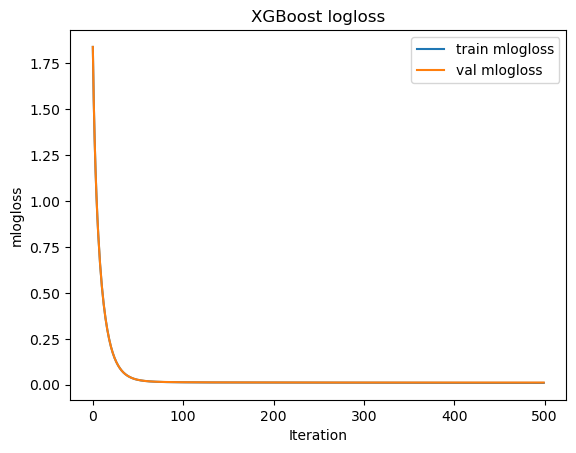

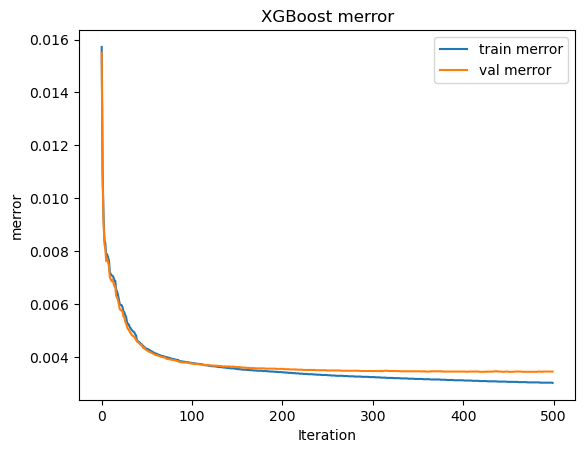

In [3]:
import re, pandas as pd, matplotlib.pyplot as plt

LOGFILE = "xgb_train.log"  # path to your saved training output
pat = re.compile(
    r"\[(\d+)\]\s+train-mlogloss:([0-9.]+)\s+train-merror:([0-9.]+)\s+val-mlogloss:([0-9.]+)\s+val-merror:([0-9.]+)"
)

rows = []
with open(LOGFILE, "r") as f:
    for line in f:
        m = pat.search(line)
        if m:
            it, tr_ll, tr_me, va_ll, va_me = m.groups()
            rows.append({
                "iter": int(it),
                "train_mlogloss": float(tr_ll),
                "train_merror": float(tr_me),
                "val_mlogloss": float(va_ll),
                "val_merror": float(va_me),
            })

curves = pd.DataFrame(rows).sort_values("iter")
curves.to_csv("training_curves_from_log.csv", index=False)

# Plot
plt.figure()
plt.plot(curves["iter"], curves["train_mlogloss"], label="train mlogloss")
plt.plot(curves["iter"], curves["val_mlogloss"],   label="val mlogloss")
plt.xlabel("Iteration"); plt.ylabel("mlogloss"); plt.legend(); plt.title("XGBoost logloss")

plt.figure()
plt.plot(curves["iter"], curves["train_merror"], label="train merror")
plt.plot(curves["iter"], curves["val_merror"],   label="val merror")
plt.xlabel("Iteration"); plt.ylabel("merror"); plt.legend(); plt.title("XGBoost merror")

plt.show()

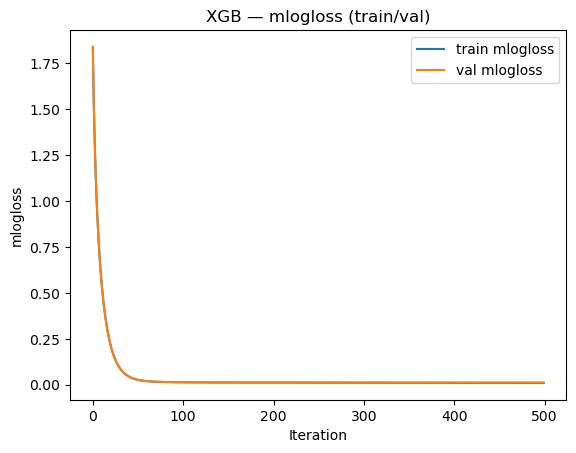

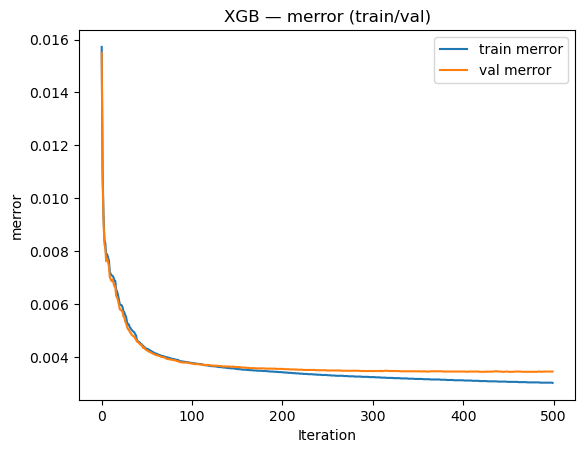

In [13]:
import re
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# === Set your log paths ===
XGB_LOG = Path("xgb_train.log")   # your existing XGBoost log
LGB_LOG = Path("lgb_train.log")   # LightGBM log (set to your path or leave missing)

# -------- XGBoost parser --------
def parse_xgb_log(path: Path) -> pd.DataFrame:
    """
    Parses lines like:
    [0]  train-mlogloss:1.95  train-merror:0.74  val-mlogloss:1.96  val-merror:0.75
    Also tolerates logloss/error metric name variants.
    """
    if not path.exists():
        return pd.DataFrame()

    rows = []
    with path.open("r", encoding="utf-8", errors="ignore") as f:
        for line in f:
            it_match = re.search(r"\[(\d+)\]", line)
            if not it_match:
                continue
            it = int(it_match.group(1))

            # collect all train-xxx:value and try to match corresponding val-xxx:value
            for m in re.finditer(r"train-([\w]+):([0-9.]+)", line):
                metric = m.group(1)
                train_val = float(m.group(2))
                val_m = re.search(rf"val-{metric}:([0-9.]+)", line)
                if not val_m:
                    # fallback: any val metric on the line (rarely needed)
                    any_val = re.search(r"val-([\w]+):([0-9.]+)", line)
                    if not any_val:
                        continue
                    val_val = float(any_val.group(2))
                else:
                    val_val = float(val_m.group(1))
                rows.append({"iter": it, f"xgb_train_{metric}": train_val, f"xgb_val_{metric}": val_val})

    if not rows:
        return pd.DataFrame()
    return (
        pd.DataFrame(rows)
        .groupby("iter").first()
        .reset_index()
        .sort_values("iter")
    )

# -------- LightGBM parser --------
def parse_lgb_log(path: Path) -> pd.DataFrame:
    """
    Parses lines like:
    [1]    train's multi_logloss:0.8745    valid_1's multi_logloss:0.9234
    [1]    train's multi_error:0.265      validation's multi_error:0.278
    Handles valid_1/validation variants.
    """
    if not path.exists():
        return pd.DataFrame()

    pat = re.compile(
        r"\[(\d+)\]\s+train's\s+([A-Za-z0-9_]+):([0-9.]+)\s+valid(?:ation)?(?:_\d+)?'s\s+([A-Za-z0-9_]+):([0-9.]+)",
        re.IGNORECASE,
    )

    rows = []
    with path.open("r", encoding="utf-8", errors="ignore") as f:
        for line in f:
            m = pat.search(line)
            if not m:
                continue
            it = int(m.group(1))
            tr_metric, tr_val = m.group(2), float(m.group(3))
            va_metric, va_val = m.group(4), float(m.group(5))
            rows.append({"iter": it, f"lgb_train_{tr_metric}": tr_val, f"lgb_val_{va_metric}": va_val})

    if not rows:
        return pd.DataFrame()
    return (
        pd.DataFrame(rows)
        .groupby("iter").first()
        .reset_index()
        .sort_values("iter")
    )

# -------- Parse & merge --------
xgb_df = parse_xgb_log(XGB_LOG)
lgb_df = parse_lgb_log(LGB_LOG)

if not xgb_df.empty:
    xgb_df.to_csv("xgb_training_curves_from_log.csv", index=False)
if not lgb_df.empty:
    lgb_df.to_csv("lgb_training_curves_from_log.csv", index=False)

if xgb_df.empty and lgb_df.empty:
    raise SystemExit("No metrics parsed. Check your log paths and formats.")

curves = (
    pd.merge(xgb_df, lgb_df, on="iter", how="outer")
    if (not xgb_df.empty and not lgb_df.empty)
    else (xgb_df if not xgb_df.empty else lgb_df)
).sort_values("iter")
curves.to_csv("training_curves_combined.csv", index=False)

# -------- Plot together when metrics match (XGB ↔ LGB) --------
def has(df, cols): return all(c in df.columns for c in cols)

# Likely equivalents for overlay
pairs = [
    # logloss
    (("xgb_train_mlogloss", "xgb_val_mlogloss"), ("lgb_train_multi_logloss", "lgb_val_multi_logloss")),
    (("xgb_train_logloss",  "xgb_val_logloss"),  ("lgb_train_binary_logloss", "lgb_val_binary_logloss")),
    # error
    (("xgb_train_merror",   "xgb_val_merror"),   ("lgb_train_multi_error", "lgb_val_multi_error")),
    (("xgb_train_error",    "xgb_val_error"),    ("lgb_train_binary_error", "lgb_val_binary_error")),
]

overlay_done = False
for (xtr, xva), (ltr, lva) in pairs:
    if has(curves, [xtr, xva]) and has(curves, [ltr, lva]):
        plt.figure()
        plt.plot(curves["iter"], curves[xtr], label=xtr.replace("xgb_", "").replace("_", " "))
        plt.plot(curves["iter"], curves[xva], label=xva.replace("xgb_", "").replace("_", " "))
        plt.plot(curves["iter"], curves[ltr], label=ltr.replace("lgb_", "").replace("_", " "))
        plt.plot(curves["iter"], curves[lva], label=lva.replace("lgb_", "").replace("_", " "))
        plt.xlabel("Iteration")
        plt.ylabel("Metric")
        plt.title("XGBoost vs LightGBM — loss/error (train & val)")
        plt.legend()
        overlay_done = True
        break

# -------- Always also make per-framework plots for any metrics found --------
def sweep(framework_prefix):
    # finds train/val pairs like f"{fw}_train_metric", f"{fw}_val_metric"
    groups = {}
    for c in curves.columns:
        if c == "iter" or not c.startswith(f"{framework_prefix}_"):
            continue
        parts = c.split("_", 2)  # e.g. xgb_train_mlogloss
        if len(parts) != 3: 
            continue
        _, split, metric = parts
        if split not in ("train", "val"):
            continue
        groups.setdefault(metric, set()).add(split)

    for metric, splits in groups.items():
        want = [f"{framework_prefix}_train_{metric}"] if "train" in splits else []
        if "val" in splits: want.append(f"{framework_prefix}_val_{metric}")
        plt.figure()
        for col in want:
            plt.plot(curves["iter"], curves[col], label=col.replace(f"{framework_prefix}_", "").replace("_", " "))
        plt.xlabel("Iteration")
        plt.ylabel(metric)
        plt.title(f"{framework_prefix.upper()} — {metric} (train/val)")
        plt.legend()

sweep("xgb")
sweep("lgb")

from datetime import datetime

OUT_DIR = Path("plots")
OUT_DIR.mkdir(parents=True, exist_ok=True)

stamp = datetime.now().strftime("%Y%m%d-%H%M%S")
for i, num in enumerate(plt.get_fignums(), start=1):
    fig = plt.figure(num)
    # Save PNG + PDF (you can add ".svg" similarly)
    fig.savefig(OUT_DIR / f"training_curves_{stamp}_{i:02d}.png", dpi=180, bbox_inches="tight")
    fig.savefig(OUT_DIR / f"training_curves_{stamp}_{i:02d}.pdf", bbox_inches="tight")

# Optional: close figs if running in batch
# plt.close('all')

plt.show()

In [11]:
from datetime import datetime

OUT_DIR = Path("plots")
OUT_DIR.mkdir(parents=True, exist_ok=True)

stamp = datetime.now().strftime("%Y%m%d-%H%M%S")
for i, num in enumerate(plt.get_fignums(), start=1):
    fig = plt.figure(num)
    # Save PNG + PDF (you can add ".svg" similarly)
    fig.savefig(OUT_DIR / f"training_curves_{stamp}_{i:02d}.png", dpi=180, bbox_inches="tight")
    fig.savefig(OUT_DIR / f"training_curves_{stamp}_{i:02d}.pdf", bbox_inches="tight")

# Optional: close figs if running in batch
# plt.close('all')

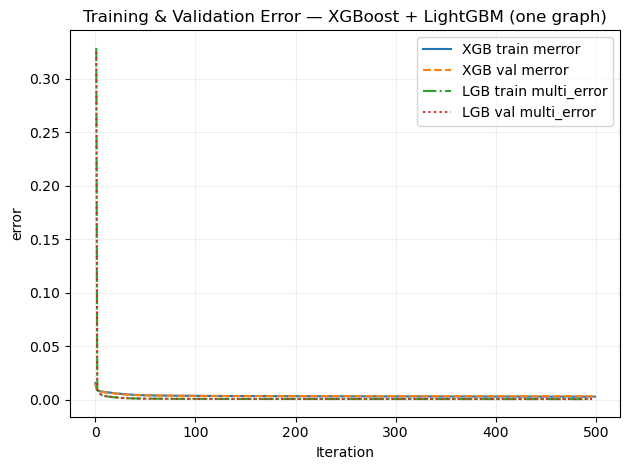

In [10]:
import re
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

# === Paths to your logs ===
XGB_LOG = Path("xgb_train.log")
LGB_LOG = Path("lgb_train.log")

# --- Parse XGBoost error (your format) ---
# [0]  train-mlogloss:...  train-merror:0.01572  val-mlogloss:...  val-merror:0.01549
xgb_err_line = re.compile(
    r"\[(\d+)\]\s+"
    r"(?:train-\w+:[0-9.]+\s+)?"               # skip other metrics (e.g., mlogloss)
    r"train-merror:\s*([0-9.]+)\s+"
    r"(?:val-\w+:[0-9.]+\s+)?"                 # skip other metrics (e.g., mlogloss)
    r"val-merror:\s*([0-9.]+)",
    re.IGNORECASE
)

def parse_xgb_error(path: Path) -> pd.DataFrame:
    rows = []
    if path.exists():
        with path.open("r", encoding="utf-8", errors="ignore") as f:
            for line in f:
                m = xgb_err_line.search(line)
                if not m:
                    continue
                it, tr_er, va_er = m.groups()
                rows.append({
                    "iter": int(it),
                    "xgb_train_merror": float(tr_er),
                    "xgb_val_merror":   float(va_er),
                })
    return pd.DataFrame(rows).sort_values("iter").reset_index(drop=True)

# --- Parse LightGBM error (your format) ---
# [1]  train's multi_logloss: ...  train's multi_error: 0.3287  val's multi_logloss: ...  val's multi_error: 0.3249
lgb_err_line = re.compile(
    r"\[(\d+)\]\s+"
    r"(?:train's\s+\w+:\s*[0-9.]+\s+)?"        # skip other metrics (e.g., multi_logloss)
    r"train's\s+multi_error:\s*([0-9.]+)\s+"
    r"(?:val's\s+\w+:\s*[0-9.]+\s+)?"          # skip other metrics (e.g., multi_logloss)
    r"val's\s+multi_error:\s*([0-9.]+)",
    re.IGNORECASE
)

def parse_lgb_error(path: Path) -> pd.DataFrame:
    rows = []
    if path.exists():
        with path.open("r", encoding="utf-8", errors="ignore") as f:
            for line in f:
                m = lgb_err_line.search(line)
                if not m:
                    continue
                it, tr_er, va_er = m.groups()
                rows.append({
                    "iter": int(it),
                    "lgb_train_multi_error": float(tr_er),
                    "lgb_val_multi_error":   float(va_er),
                })
    return pd.DataFrame(rows).sort_values("iter").reset_index(drop=True)

xgb = parse_xgb_error(XGB_LOG)
lgb = parse_lgb_error(LGB_LOG)

if xgb.empty and lgb.empty:
    raise SystemExit("No error metrics parsed. Check your log paths and formats.")

# Optional: save parsed CSVs
if not xgb.empty: xgb.to_csv("parsed_xgb_error.csv", index=False)
if not lgb.empty: lgb.to_csv("parsed_lgb_error.csv", index=False)

# --- Single figure: all errors on ONE axes ---
plt.figure()
if not xgb.empty:
    plt.plot(xgb["iter"], xgb["xgb_train_merror"], linestyle="-",  label="XGB train merror")
    plt.plot(xgb["iter"], xgb["xgb_val_merror"],   linestyle="--", label="XGB val merror")
if not lgb.empty:
    plt.plot(lgb["iter"], lgb["lgb_train_multi_error"], linestyle="-.", label="LGB train multi_error")
    plt.plot(lgb["iter"], lgb["lgb_val_multi_error"],   linestyle=":",  label="LGB val multi_error")

plt.xlabel("Iteration")
plt.ylabel("error")
plt.title("Training & Validation Error — XGBoost + LightGBM (one graph)")
plt.legend()
plt.grid(True, which="both", axis="both", alpha=0.2)
plt.tight_layout()
plt.show()
